In [3]:
import torch
import wandb
from u_net import U_Net
import matplotlib.pyplot as plt
from data import get_data, view
from loops import training_loop, performance_report

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
wandb.login()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mkwambetumelo to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
train_data = get_data('train', [2, 7, 10, 12, 21, 24, 27, 28, 30, 43])
val_data = get_data('val', [1, 11, 22, 32])
test_data = get_data('test', [4, 16, 29, 36])

In [6]:
model = U_Net(
    in_channels = 3,
    out_channels = 2,
    start_channels = 64,
    depth = 4,
    bilinear = False
)

In [7]:
model = training_loop(
    model = model,
    training_data = train_data,
    validation_data = val_data,
    run_name = "unet_run3",
    batch = 4,
    learning_rate = 1e-3,
    num_epochs = 15,
    device = device
)

torch.torch.cuda.empty_cache()

Epoch: 0
Training | Loss: 0.6697921951611837
Validation | Loss: 0.5622801184654236 | IoU: 0.0 | Accuracy: 0.7605050404866537 | Precision: 0.0 | Recall: 0.0 | F1: 0.0 

Epoch: 1
Training | Loss: 0.6257030765215555
Validation | Loss: 0.46884283423423767 | IoU: 0.0 | Accuracy: 0.7605050404866537 | Precision: 0.0 | Recall: 0.0 | F1: 0.0 

Epoch: 2
Training | Loss: 0.55242387453715
Validation | Loss: 0.5155113339424133 | IoU: 0.0 | Accuracy: 0.7605050404866537 | Precision: 0.0 | Recall: 0.0 | F1: 0.0 

Epoch: 3
Training | Loss: 0.5620659788449606
Validation | Loss: 0.49517667293548584 | IoU: 0.0 | Accuracy: 0.7605050404866537 | Precision: 0.0 | Recall: 0.0 | F1: 0.0 

Epoch: 4
Training | Loss: 0.5425731142361959
Validation | Loss: 0.4287162125110626 | IoU: 0.0 | Accuracy: 0.7605050404866537 | Precision: 0.0 | Recall: 0.0 | F1: 0.0 

Epoch: 5
Training | Loss: 0.5131872594356537
Validation | Loss: 0.37901759147644043 | IoU: 0.0 | Accuracy: 0.7605050404866537 | Precision: 0.0 | Recall: 0.0 | F

Training Loss,▁▁▁▁▁▁▁▁▁▁▁▁█▁▁
Validation Accuracy,▆▆▆▆▆▆▇████▁▇▇▆
Validation F1,▁▁▁▁▁▁▄▇███▄▆▅▃
Validation IoU,▁▁▁▁▁▁▃▇██▇▃▅▄▂
Validation Loss,▁▁▁▁▁▁▁▁▁▁▁█▁▁▁
Validation Precision,▁▁▁▁▁▁███▇█▃███
Validation Recall,▁▁▁▁▁▁▃▆▇█▇█▄▄▂
Training Loss,0.71538
Validation Accuracy,0.80295
Validation F1,0.30111
Validation IoU,0.17724


In [24]:
model = model.to("cpu") # move model to cpu from cuda
image = test_data[3][0]
image = image.unsqueeze(0)
out_image = model(image)

In [25]:
out_image = torch.argmax(out_image, dim = 1)
out_image = out_image.squeeze(0)

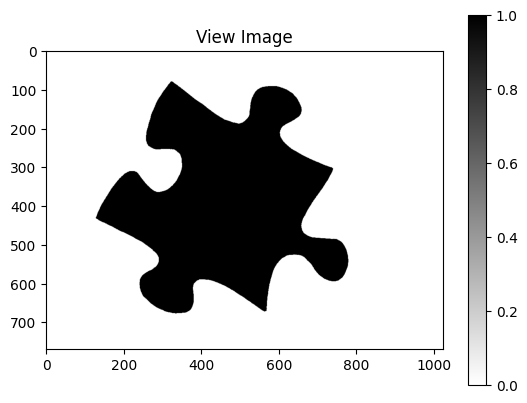

In [26]:
view(test_data[3][1])

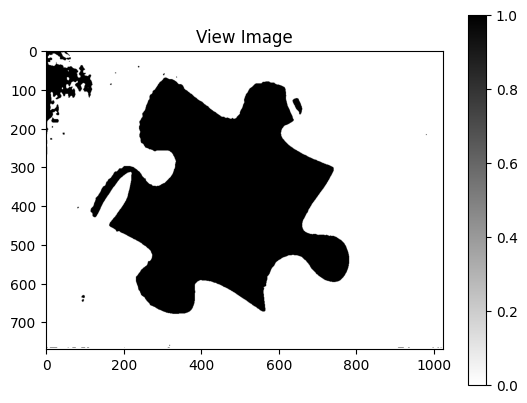

In [27]:
view(out_image)

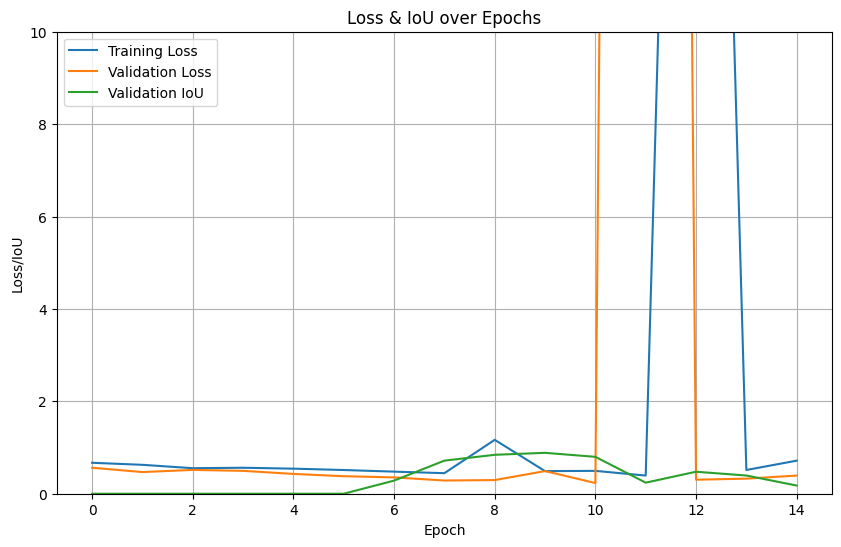

In [33]:
api = wandb.Api()

run = api.run("computer-vision-wits/U-Net/yy1e3i17")

history = run.history()

plt.figure(figsize=(10, 6))
plt.plot(history['Training Loss'], label='Training Loss')
plt.plot(history['Validation Loss'], label='Validation Loss')
plt.plot(history['Validation IoU'], label='Validation IoU')
plt.title('Loss & IoU over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss/IoU')
plt.ylim(0, 10)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
'''
Based on the graphs and the provided metrics, the model is not overfitting. The training loss exceed the validation loss, with the
exception of epoch 10, where the validation loss is slightly higher than the training loss.
Both the training and validation curves indicate that the model is still learning and improving.
A sign of overfitting is when the training loss continues to decrease, but the validation loss begins to increase or remain stagnant.
In the above graphs, both training and validation loss are decreasing, which suggests the model is still improving on unseen data.

If the model were overfitting, we would implement early stoppage and halt the training process provided that the training loss
decreases but the validation loss stays constant. Another option to eliminate the chances of overfitting is to incorporate regularization
techniques such as dropout or weight decay.
'''

In [40]:
loss, accuracy, precision, recall, f1, iou = performance_report(
    model = model,
    data = test_data,
    batch_size = 1,
    device = "cpu"
)

print("Performance Report of Best Model By Validation IoU")
print(f"Loss: {loss} | IoU: {iou} | Accuracy: {accuracy} | Precision: {precision} | Recall: {recall} | F1: {f1} \n")

Performance Report of Best Model By Validation IoU
Loss: 0.5309378355741501 | IoU: 0.7091754530425064 | Accuracy: 0.8988393147786459 | Precision: 0.7276061044767163 | Recall: 0.9655135086710812 | F1: 0.8298451183348109 

